In [367]:
import pandas as pd
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import math
import random
sns.set(font_scale=1.56)
# from eli5.sklearn import PermutationImportance
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from mlxtend.regressor import StackingRegressor
from mlxtend.data import boston_housing_data
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn import preprocessing
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
# for display dataframe
from IPython.display import display
from IPython.display import display_html
import warnings

warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

In [368]:
weight = pd.read_csv('./weight.csv',index_col=0) #將第一欄當名稱
machine = pd.read_csv('./machine.csv',index_col=0)

In [369]:
weight

,PEP1_weight,PEP2_weight,PEP3_weight,PEP4_weight
c1,0.90,0.5,0.9,0.9
c2,0.90,0.8,1.0,1.0
c3,0.90,0.7,0.5,0.5
c4,1.00,0.7,0.7,0.7
c5,0.95,0.9,0.9,0.9
c6,0.85,0.6,0.4,0.4
c7,1.00,0.8,0.6,0.6
c8,0.93,0.7,0.3,0.3
c9,0.94,0.9,0.8,0.8
c10,0.88,0.8,0.4,0.4


In [370]:
machine

,U%,PP,MURA,MURA2
V1,0.985,0.912,0.889,0.889
V2,0.988,0.922,0.956,0.956
V3,0.999,0.923,0.877,0.877
V4,0.999,0.931,0.877,0.877
V5,0.999,0.000,0.955,0.955
V6,0.997,0.000,0.959,0.959
V7,0.995,0.000,0.999,0.999
V8,0.997,0.000,0.987,0.987
V9,0.941,0.997,0.965,0.965
V10,0.951,0.987,0.953,0.953


In [394]:
class Gene:
    # 隨機產生基因染色體：隨機產生 pop_size 組，維度為 pop_dim，長度為 chrom_length 的染色體。
    # 每個染色體皆是0或是1，長度越長代表細分程度越高。    
    def geneEncoding(pop_size,chromosome_length):
        pop = []
        for i in range(pop_size):            
            temp = []
            length_sum = 0
            for j in range(0,len(chromosome_length)):
                if j == 0:
                    length_sum = length_sum
                else:
                    length_sum = length_sum + chromosome_length[j-1]
                    
                tmp_gene_sum = 0
                for a in range(length_sum,length_sum + chromosome_length[j]):
                    tmp_gene = random.randint(0, 1)
                    tmp_gene_sum = tmp_gene_sum + tmp_gene
                    if a == length_sum + chromosome_length[j]-1:
                        #最後一個
                        if tmp_gene_sum > 1:
                            #總和大於1
                            temp.append(0)
                            tmp_gene_sum = tmp_gene_sum - tmp_gene + 0
                        elif tmp_gene_sum == 1:
                            if tmp_gene == 0:
                                temp.append(0)
                                tmp_gene_sum = tmp_gene_sum - tmp_gene + 0
                            else:
                                temp.append(1)
                                tmp_gene_sum = tmp_gene_sum - tmp_gene + 1
                        elif tmp_gene_sum == 0:
                            #總和等於0
                            temp.append(1)                        
                            tmp_gene_sum = tmp_gene_sum - tmp_gene + 1
                    else:
                        #非最後一個
                        if tmp_gene_sum > 1:
                            #總和大於1
                            temp.append(0)
                            tmp_gene_sum = tmp_gene_sum - tmp_gene + 0
                        elif tmp_gene_sum == 1:
                            if tmp_gene == 0:
                                temp.append(0)
                                tmp_gene_sum = tmp_gene_sum - tmp_gene + 0
                            else:
                                temp.append(1)
                                tmp_gene_sum = tmp_gene_sum - tmp_gene + 1
                        elif tmp_gene_sum == 0:
                            #總和等於0
                            temp.append(0)
                            tmp_gene_sum = tmp_gene_sum - tmp_gene + 0
            pop.append(temp)
        return pop
    
    #計算fitness總和
    def fit_sum(fit_value):    
        total = 0
        for i in range(len(fit_value)):
            total += fit_value[i]
        return total   
    
    #計算累加機率
    def cumsum(fit_value):
        #從倒數第二個開始倒數到第0個
        for i in range(len(fit_value)-2, -1, -1):
            t = 0
            j = 0
            while(j <= i):
                t += fit_value[j]
                j += 1
            fit_value[i] = t
        fit_value[len(fit_value)-1] = 1 # 最後一個值填1
        return fit_value          
            
    
    #輪盤選擇法
    def selection(pop, fit_value, target):
        if target == 'max':
            for i in range(len(fit_value)):
                fit_value[i] = fit_value[i] - min(fit_value) + 0.001
        #如果是望小的話會將結果進行倒數結果，分母會固定加上0.001，避免分母為0
        elif target == 'min': 
            for i in range(len(fie_value)):
                fit_value[i] = 1 / ((fit_value[i] - min(fit_value))  + 0.001)
        
        newfit_value = []
        total_fit = Gene.fit_sum(fit_value)
        #個體fit佔總體fit比例
        for i in range(len(fit_value)):
            # 把Ｙ全部除以Ｙ總和，得到個體適應機率
            newfit_value.append(fit_value[i] / total_fit)
        # 把個體適應機率丟進 cumsum 計算累進個體適應機率
        Gene.cumsum(newfit_value)
        
        ms = []
        pop_len = len(pop)
        #隨機生成標靶 0 ~ 1
        for i in range(pop_len):
            ms.append(random.random())
        #由小到大排序
        ms.sort()
        fitin = 0
        newin = 0
        newpop = pop
        
        # 輪盤選擇法的迴圈（挑選和複製）
        while newin < pop_len:
            if ms[newin] < newfit_value[fitin]:
                newpop[newin] = pop[fitin]
                newin = newin + 1
            else:
                fitin = fitin + 1
        return newpop

    
    #交配，隨機的機率將pop[i]與pop[i+1]內的隨機位置進行交換
    def crossover(pop,pc,chromosome_length):
        #最後一個無法交換，所以 -1
        for i in range(len(pop) - 1):
            if random.random() < pc:
                cpoint = random.randint(0,len(chromosome_length))
                cpoint = sum(chromosome_length[0:cpoint])
                #print(cpoint)
                temp1 = []
                temp2 = []
                temp1.extend(pop[i][0:cpoint])
                temp1.extend(pop[i+1][cpoint:])
                temp2.extend(pop[i+1][0:cpoint])
                temp2.extend(pop[i][cpoint:])
                pop[i] = temp1
                pop[i+1] = temp2
                
        return pop

    
    #突變，隨機機率將其中一個組值的0改成1，或是1改0
    #但必須加入判斷式同一組不可出現多個1，或是全部0
    def mutation(pop,pm,chromosome_length):
        for i in range(len(pop)):
            if random.random() < pm:
                mpoint = random.randint(0,len(chromosome_length)-1)
                if mpoint == 0:
                    mstart = 0 #可能mutation 的起始點
                    mend = chromosome_length[0]-1 #可能mutation 的結束點
                elif (mpoint == len(chromosome_length)-1):
                    mstart = sum(chromosome_length[:(mpoint)]) #可能mutation 的起始點
                    mend = sum(chromosome_length)-1 #可能mutation 的結束點
                else:
                    mstart = sum(chromosome_length[:mpoint]) #可能mutation 的起始點
                    mend = sum(chromosome_length[:(mpoint+1)])-1 #可能mutation 的結束點
                    
                mpoint2 = random.randint(mstart,mend)
                while pop[0][mpoint2] == 1:
                    mpoint2 = random.randint(mstart,mend)
                else:
                    break
                    
                #針對要突變的chromosome做順序的調整，不出現多個1或是全部為0
                for j in range(mstart,mend):
                    if j == mpoint2:
                        pop[i][mpoint2] = 1
                    else:
                        pop[i][mpoint2] = 0
        print(pop)
        print("next")
        return pop
                        

    #找出最佳解與基因組合的位置，並儲存
    #挑選適應度好的，利用機率的方式讓壞的結果也可能會變成最好   
    def find_best(fit_value, pop, target):
        count = -1 
        if target == 'max':
            Best = -99999999
                        
            Best = max(fit_value)
            Best_index = fit_value.index(max(fit_value))
            if len(BestValue) ==0:
                BestValue.append(fit_value[Best_index])
                BestGene.append(pop[Best_index])
            else:
                if BestValue[len(BestValue) - 1] < fit_value[Best_index]:
                    BestValue.append(fit_value[Best_index])
                    BestGene.append(pop[Best_index])
                else:
                    BestValue.append(BestValue[len(BestValue) - 1])
                    BestGene.append(BestGene[len(BestGene) - 1])
            print('Best Gene : ' + str(BestValue[len(BestValue) - 1]))
            print('Best Gene : ' + str(BestGene[len(BestGene) - 1]))


#             for i in range(len(fit_value)):
#                 if Best < fit_value[i]:
#                     Best = fit_value[i]
#                     count = i
#             if len(BestValue) == 0:
#                 BestValue.append(fit_value[i])
#                 BestGene.append(pop[i])
#             else:
#                 if BestValue[len(BestValue) - 1] < fit_value[i]:
#                     BestValue.append(fit_value[i])
#                     BestGene.append(pop[fit_value.index(max(fit_value))])
#                 else:
#                     BestValue.append(BestValue[len(BestValue) - 1])
#                     BestGene.append(BestGene[len(BestGene) - 1])
#             #print('Best Gene : ' + str(BestValue))
#             #print('Best Gene : ' + str(BestGene))
#         elif target == 'min':
#             Best = 99999999
#             for i in range(len(fit_value)):
#                 if Best > fit_value[i]:
#                     Best = fit_value[i]
#                     count = i
#             if len(BestValue) == 0:
#                 BestValue.append(fit_value[i])
#                 BestGene.append(pop[i])
#             else:
#                 if BestValue[len(BestValue) - 1] > fit_value[i]:
#                     BestValue.append(fit_value[i])
#                     BestGene.append(pop[i])
#                 else:
#                     BestValue.append(BestValue[len(BestValue) - 1])
#                     BestGene.append(BestGene[len(BestGene) - 1])
                
            
            
        #idx = np.random.choice(np.arange(pop_size), size=pop_size, replace = True, p=fit_value / np.array(fit_value).sum())
    
    #挑選適應度好的，直接選分數最高的作為結果      

In [395]:
# 在這裡定義目標式，這裡是範例：
# y = 10 * math.sin(5 * a) + 7 * math.cos(4 * b)

def calobjValue(pop,chromosome_length,machine,weight_give): 
    obj_value = []
    score = 0
    weight_list = list(weight_give)
    for i in range(len(pop)):
        score = 0
        length_sum = 0
        for j in range(0,len(chromosome_length)):
            if j == 0:
                length_sum = length_sum
            else:
                length_sum = length_sum + chromosome_length[j-1]
                
            for a in range(length_sum,length_sum + chromosome_length[j]):
                #依據組合將score算出
                if pop[i][a] == 1:
                    for b in range(machine.shape[1]):
                        #print(str(machine.iloc[a][b]) + 'and' +  str(weight_give.iloc[0][j])) 檢查計算正確
                        score = score + machine.iloc[a][b] * weight_give.iloc[0][j]
        obj_value.append(score)
    #print(obj_value)
    #print("next")
    return obj_value


In [398]:
#參數設定

loop_times = 500 # 迭代次數
pop_size = 5 # 基因組數/母體數量
pc = 0.8 #交配機率，設0代表不進行交配
pm = 0.1 #變異機率，設0代表不進行突變

chromosome_length = [4,4,4,4] # 染色體長度，越大代表細分程度越高，也代表要跑越久（細分程度 = 2^chromosome_length）
target = 'max' #望大或望小
BestValue = [] #儲存最佳解
BestGene = [] #儲存最佳基因組

weight_give = weight.iloc[:][0:1]#指定產品

Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0], [1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0], [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]
next
Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]
next
Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0

Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]
next
Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]
next
Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0

Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]
next
Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]
next
Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0

Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]
next
Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]
next
Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0

Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]
next
Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]
next
Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0

Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]
next
Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]
next
Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0

Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]
next
Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]
next
Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0

Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]
next
Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]
next
Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0

Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]
next
Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]
next
Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0

Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]
next
Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]
next
Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0

Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]
next
Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]
next
Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0

Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]
next
Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]
next
Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0

Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]
next
Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]
next
Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0

Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]
next
Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]
next
Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0

Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]
next
Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]
next
Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0

Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]
next
Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0]]
next
Best Gene : 11.8552
Best Gene : [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]
[[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0

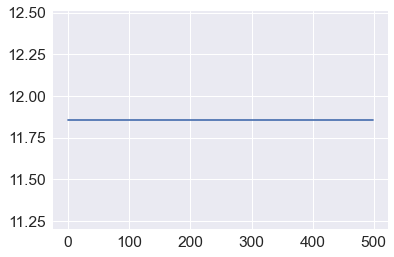

<Figure size 1500x1000 with 0 Axes>

In [399]:
#基因演算法求最佳解
pop = Gene.geneEncoding(pop_size, chromosome_length) #產生母體

for i  in range(loop_times):
    
    #decodechromosome 將二進制轉成十進制，再轉成一定範圍
    #計算f(x)
    fit_value = calobjValue(pop.copy(),chromosome_length,machine,weight_give)
    #挑選適應度好
    Gene.find_best(fit_value, pop, target)
    #利用輪盤選擇法進行挑選複製
    newpop = Gene.selection(pop,fit_value.copy(),target)
    final_pop = Gene.mutation(Gene.crossover(newpop.copy(),pc,chromosome_length),pm,chromosome_length)
    pop = final_pop.copy()
    

print('Best Gene : ' + str(BestGene[len(BestGene) - 1]))
print('Best Value : ' + str(BestValue[len(BestValue) - 1]))
plt.plot(BestValue[1:])
plt.figure(figsize=(15,10),dpi=100,linewidth = 2)
plt.show()


In [252]:
mpoint = random.randint(0,len(chromosome_length)-1)
mpoint

1

In [253]:
chromosome_length[mpoint]

3

In [265]:
random.randint(2,3)

2

In [372]:
for i in range(3,5):
    print(i)


3
4


In [274]:
sum(chromosome_length[:1])+1

4

In [275]:
sum(chromosome_length[:2])

6

In [395]:
pop[0][0]

0

In [358]:
mstart = 3
mend = 5
mpoint2 = random.randint(mstart,mend)
while pop[0][mpoint2] == 1:
    mpoint2 = random.randint(mstart,mend)
else:
     print(mpoint2)
print("end")
    

4
end


In [382]:
sum(chromosome_length[:3])-1

8

In [31]:
fit_value.index(max(fit_value))

0

In [57]:
len(BestGene)

500

In [313]:
max(fit_value)

11.818300000000001

In [314]:
fit_value.index(max(fit_value))

1

In [316]:
fit_value


[11.686,
 11.818300000000001,
 11.818300000000001,
 11.686,
 11.686,
 11.686,
 11.818300000000001,
 11.686,
 11.686,
 11.686,
 11.686,
 11.686,
 11.725900000000003,
 11.725900000000003,
 11.725900000000003,
 11.725900000000003,
 11.725900000000003,
 11.725900000000003,
 11.725900000000003,
 11.725900000000003]